https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP_Week_1_Lesson_2.ipynb

In [44]:
import numpy as np
import matplotlib.pyplot as plt


In [45]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legent(fontsize=4)
    plt.grid(True)

# Trend & Seasonality

In [46]:
def trend(time, slope=0):
    return slope * time

## Trend only

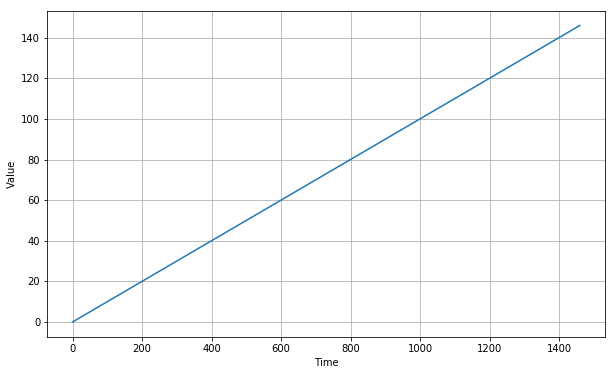

In [47]:
# just a time series that trend upward
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()


In [48]:
def seasonal_pattern(season_time):
    
    return np.where(
        season_time < 0.4,
        np.cos(season_time * 2 * np.pi), # when < 0.4
        1 / np.exp(3 * season_time)      # when >= 0.4
    )

def seasonality(time, period, amplitude=1, phase=0):
    # 在1個period (1 year) 中的哪個位置
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

## Seasonality only

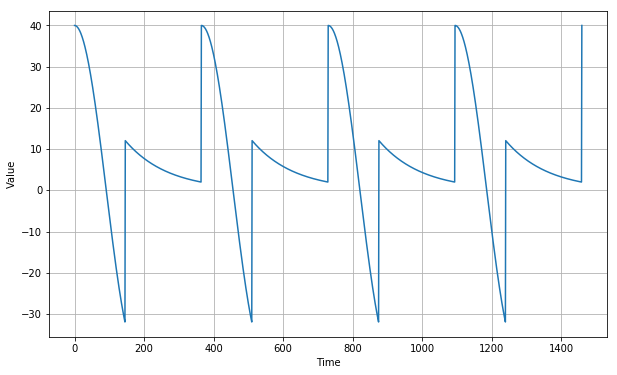

In [49]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Trend + Seasonality

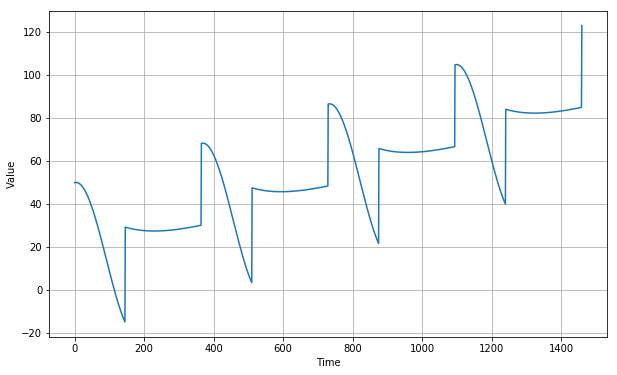

In [50]:


slope = 0.05
# 其實就是純粹array + array
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)


## Noise

In [51]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

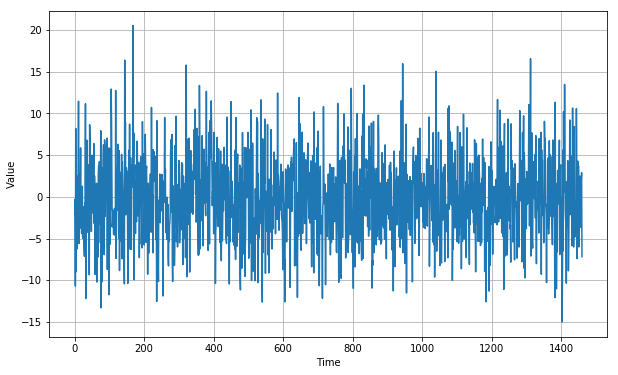

In [52]:
# 純粹的noise
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

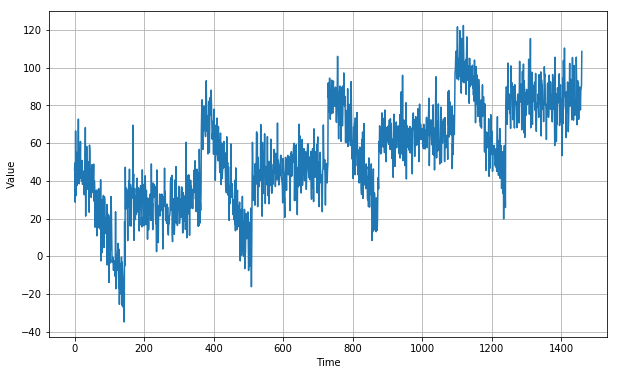

In [54]:

# 這邊的series已經有3層了(baseline, trend, seasonality), 再加一層上去
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [66]:
# AR function alt1
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    # 因為會用到t-50，所以這裡前面要先"pad" 50個values
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [71]:
# AR function alt2
"""
RandomState.randn
Return a sample (or samples) from the “standard normal” distribution.
returns ndarray
"""

def autocorrelation(time, amplitude, seed=None):
    
    rnd = np.random.RandomState(seed)
    φ = 0.8
    # initialize with a series of random floats (?!)
    ar = rnd.randn(len(time) + 1)
    
    # t & t-1 的auto-correlation
    # 真正的AR關係在這
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
        
    return ar[1:] * amplitude

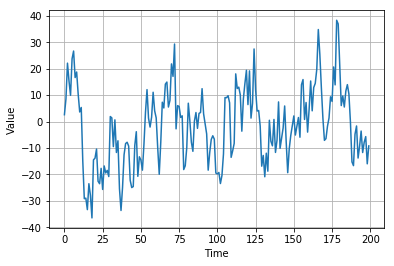

In [72]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

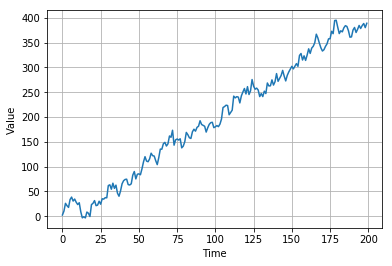

In [73]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

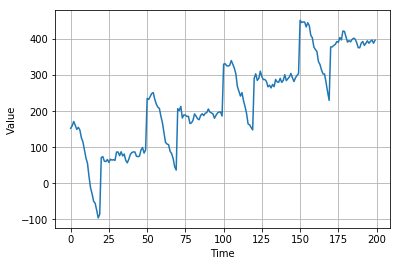

In [74]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

## Non-stationary Time-series: Patter change

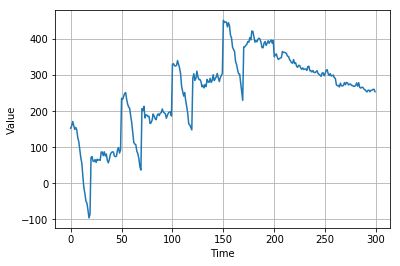

In [75]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [79]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] = rnd.rand() * amplitude
    return series

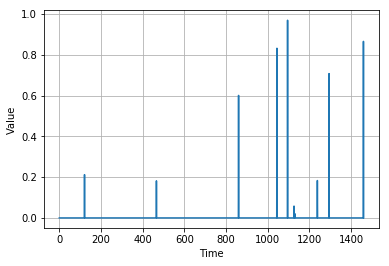

In [80]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [84]:
def autocorrelation(source, φs):
    # the source here is the impulses
    ar = source.copy()
    # max_lag is not used
    max_lag = len(φs)
    
    # this is just index & value, iterating through the 'impulses' series
    for step, value in enumerate(source):
        # φs = φ series, here, len(φs) = 1
        for lag, φ in φs.items():
            if step - lag > 0:
                # 這裡其實很簡單，就是curr step為prev step * 0.99
                ar[step] += φ * ar[step - lag]
    return ar

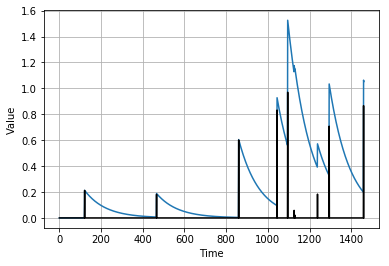

In [87]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})

plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

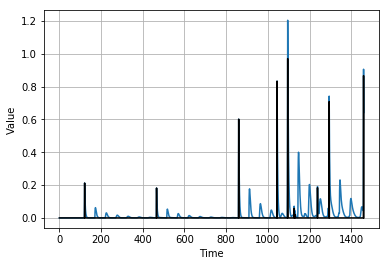

In [88]:
signal = impulses(time, 10, seed=42)
# 跟lag前1步＆lag前50步有auto-correlation關係
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

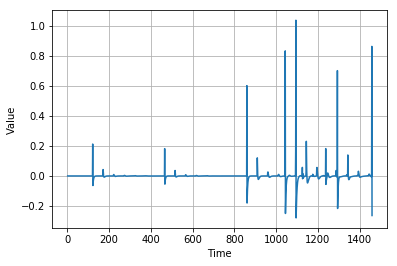

In [89]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)